# Lab 05 - Implementing CNNs

<a target="_blank" href="https://colab.research.google.com/github/andrew-nash/CS6421-labs-2026/blob/main/Lab05.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

This lab will guide you through the implementation of CNs in Jax, which will further your understanding, and help you to use CNNs more effectively. 


We will implemet our own custom CNN operation, that will mimic most of the functions of PyTorch's `Conv2D` implementation:

```python3
class torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
```

In [54]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor

import jax
import jax.numpy as jnp

import numpy as np
import matplotlib.pyplot as plt

import random

# Input Data

Assume that inputs will take the form of 28x28 pixel images of handwritten images.

We will take the standard MNIST dataset from PyTorch, and convert it to a Jax array of 6000

In [16]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

In [42]:
x_input_data=jnp.array(training_data.data.numpy())
y_input_data=jnp.array(training_data.targets.numpy())

# Rescale x_input_data to range [0,1]
x_input_data=x_input_data/255

Visualising some

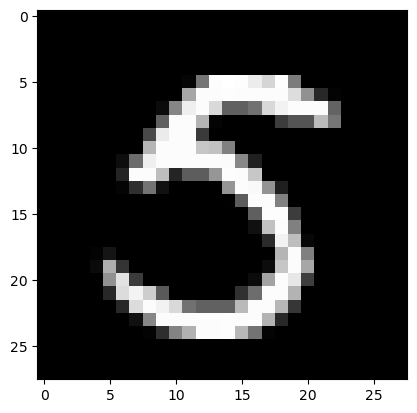

In [73]:
plt.imshow(x_input_data[random.randint(0,59999)], cmap='grey')

# Reminder on Fully Connected layers

As a quick reminder, if we want to apply a fully-connected layer to this image, we must 

1. Flatten the image to a vector $x$ (consider this to be a row-vector)
2. Define a weight matrix $W$ and bias vector $B$
3. Apply the weight and bias as $x\cdot W + b$


Consider the case of a 10 neuron layer:

In [78]:
jax_key = jax.random.key(42)


[  2.1200523 -11.311775    2.6428971 -19.576715    7.9739423  -5.458091
  -4.624563  -13.866322   -3.0953581  -3.9787498]


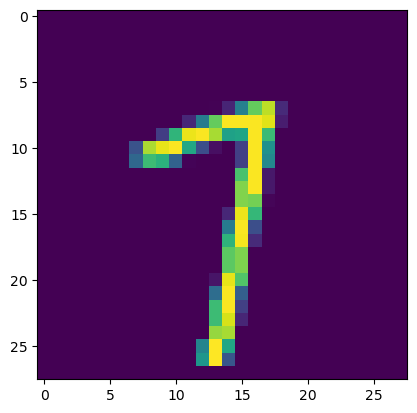

In [89]:
sample = x_input_data[42]
plt.imshow(sample)

flattened_sample = sample.reshape(784,)

## Initialise the parameters 
W = jax.random.normal(jax_key, (784,10))
b = jnp.zeros(10)

## Apply the layer to the input:
layer_out = flattened_sample@W+b
print(layer_out)

To create a complete (albeit basic) model, we can add a softmax activation:

In [96]:
activation = jax.nn.softmax(layer_out)
print(activation.round(3))

[0.003      0.         0.005      0.         0.99200004 0.
 0.         0.         0.         0.        ]


## Counting the weights

Of key note here, is the sizeof the weight matrix and bias vector. Even though this is the smalles possible fully-connected model (that doesn't discard any input data), we still see $10\times784=7840$ weights and $10$ biases, for a total of $7850$ trainabale parameters. 

# Defining A CNN-Filter

To closely mirror what you have seen in the lectures, we will define a $3\times 3$ CNN filter, in this case consistin of realisations of a standard normal distribution:


In [112]:
kernel = jax.random.normal(jax_key, (3,3))
print(kernel)

[[-0.02830462  0.46713185  0.29570296]
 [ 0.15354592 -0.12403282  0.21692315]
 [-1.4408789   0.7558599   0.52140963]]


For a practical model, we don't just apply one filter -- we apply multiple filters in parallel. We can simply initialise these filters all together with:

In [113]:
num_filters = 5
kernels = jax.random.normal(jax_key, (num_filters,3,3))
print(kernels)

[[[-0.02830462  0.46713185  0.29570296]
  [ 0.15354592 -0.12403282  0.21692315]
  [-1.4408789   0.7558599   0.52140963]]

 [[ 0.9101704  -0.3844966   1.1398233 ]
  [ 1.4457862   1.0809066  -0.05629321]
  [ 0.9095945   0.55734617  0.21905719]]

 [[-1.4485087   0.7641875  -0.24154697]
  [-1.179381   -1.9389184   0.35626462]
  [-0.24111967  1.2151275  -1.3952221 ]]

 [[-0.5347689   0.27067557  1.5401242 ]
  [ 0.69351864 -0.10387676 -0.502307  ]
  [ 0.6771835   0.11085007 -0.34774947]]

 [[ 0.45490286  0.22783831 -0.5570452 ]
  [-0.8830111  -0.21350063  0.3080113 ]
  [-0.18721904  0.09363542  0.37388122]]]


## Bias Vector

One thing which you may not have seen, is where the bias is applied in a CNN layer.

PyTorch defines a single bias parameter for each filter. This bias value is added to the feature map, after the convolution operation and before the applicaiton of the activation function 

In [115]:
biases = jax.random.normal(jax_key, (num_filters))
print(biases)

[-0.02830462  0.46713185  0.29570296  0.15354592 -0.12403282]


# Compare the Memory Usage of The CNN filter and fully-connected layer

Where out smallest possible fully-connected layer has 7850 neurons, our layer with 5 CNN filters contains 5x3x3=45 parameters in the filters themselves, and 5 biases. This is 50/7850=0.0064% of the memory usage of the fully-connected model! 

# Applying the CNN Filter (Stride=1, no bias)

Applying the filter is done exactly as you have seen in the lecture, and is well described by this animated image:

<table>
    <tr>
        <td><img src='https://miro.medium.com/max/2340/1*Fw-ehcNBR9byHtho-Rxbtw.gif' width="500px"/></td><td><img src='https://towardsdatascience.com/wp-content/uploads/2020/08/1r13ZUdVTQwVuhDPmo3JKag.png' width='500px'/></td>
    </tr>
</table>

Bear in mind, that mathematically speaking, this corresponds to a 2-Dimensional Cross-correlation oepration rather than a true convolution. In practice, this makes for a simpler implementation, wihtout any consequences on trinainability.

The key challenge here is to understand the relation between:

1. The shape of the input
2. The shape of the filter
3. The shape of the resulting feature map 


Observe how, in the above image, we have

1. A 5x5 image
2. A Single 3x3 filter
3. A resulting 3x3 feature map

The general formula to compute the dimensions (height and width for a square input, and square filter) of the feature map, is:

\begin{equation}
    D_i - D_f +1
\end{equation}

Where $D_i$ is the dimension (both Height and Width) of the input image, and $D_f$ that of the filter.

The key to deriving this, is to image you start with a filter placed at the upper left corner of the image. Consider moving the filter to the right in steps of one stride across the image, until it is not possibel to move any more. Observe where the top left coner *of the filter* is now positioned, in relation to *the right hand side of the image*. 

In [128]:
image_width = 28 # images are 28*28 pixels
image_height = 28

filter_height = 3 # filters/kernels are all 3x3
filter_width = 3

out_height = image_height - filter_height + 1
out_width=out_height
output_map = jnp.zeros((out_height,out_height))

In [129]:
print(output_map.shape)

(26, 26)


So, once we apply our filter, the result will end up in a 26x26 output

## Applying the filter

To do this, we loop over all the possible placements of the filter in the image. Our loops will track the coordinates of the placement of the upper left corner of the filter

We will apply the first filter of `kernels`, to the `sample` image, and store the result in `output_map`

In [141]:
filter_to_apply = kernels[0]
out_height = image_height - filter_height + 1
out_width=out_height

for i in range(out_height):
    for j in range(out_width):
        # Extract the segment of the image to which we convolve
        image_segment = sample[i:i+filter_height,j:j+filter_width]
       
        # apply the convolution (cross-correlation) which is simply
        # the sum of the element-wise product of the two identicaly shaped
        # matrices, and save this to the correct index of the output
        conv_res = jnp.sum(filter_to_apply*image_segment)
        
        # inefficient to use jax like this (copying the output array every time), but will keep the code simple
        output_map = output_map.at[i,j].set(conv_res)
       

Visualising the feature map:

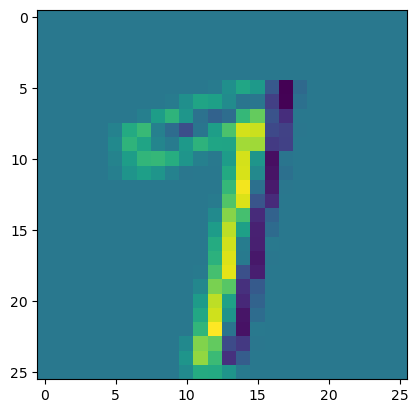

In [145]:
plt.imshow(output_map)

## Geralising this to multiple filters

To make this work with multiple features, we imply add a filter dimension to the output, and loop over each over the features in turn:

In [146]:
num_filters = len(kernels)
output_map = jnp.zeros((num_filters, out_height,out_height))
out_height = image_height - filter_height + 1
out_width=out_height

for i in range(out_height):
    for j in range(out_width):
        # Extract the segment of the image to which we convolve
        image_segment = sample[i:i+filter_height,j:j+filter_width]

        for f in range(num_filters):
            filter_to_apply = kernels[f]
            # apply the convolution (cross-correlation) which is simply
            # the sum of the element-wise product of the two identicaly shaped
            # matrices, and save this to the correct index of the output
            conv_res = jnp.sum(filter_to_apply*image_segment)

            # inefficient to use jax like this (copying the output array every time), but will keep the code simple
            output_map = output_map.at[f,i,j].set(conv_res)


In [147]:
output_map.shape

(5, 26, 26)

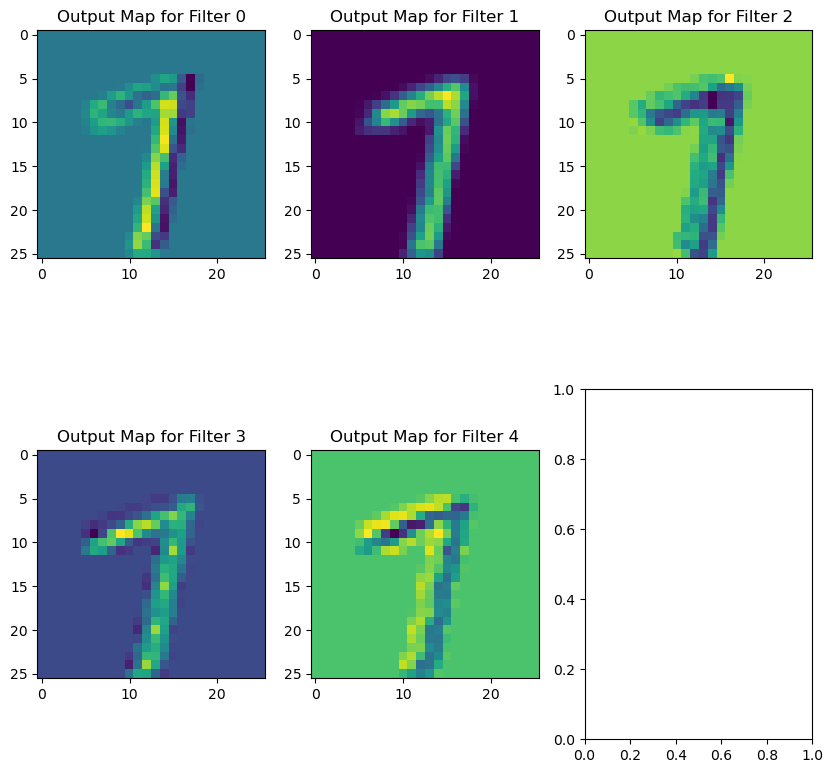

In [159]:
fig,ax = plt.subplots(2,3, figsize=(10,10))
ax=ax.flatten()
for i in range(num_filters):
    ax[i].imshow(output_map[i,:,:])
    ax[i].set_title(f'Output Map for Filter {i}')


# Applying the CNN Filter (Stride>1)

When the stride is increased beyond 1, you must be more careful in your calculation of the output map's dimension.

### Exercise

**Derive, and understand the formula for the output dimension, where the stride is 2**

The formula for an arbiritry stride is:

\begin{equation}\displaystyle
   \lfloor\frac{ D_i - D_f}{S}\rfloor +1
\end{equation}

Where S is the stride.

Therefire, where we apply our 3x3 filter to a 28x28 image, our output will have dimension 13x13, since $(28-3)/2+1=25/2+1=12+1=13$

In [164]:
num_filters = len(kernels)
stride = 2

out_height = (image_height - filter_height)//stride + 1
out_width = out_height

output_map = jnp.zeros((num_filters, out_height,out_height))

for i in range(out_height):
    for j in range(out_width):
        # Extract the segment of the image to which we convolve
        
        # the only change here is that we multiply i and j by stride
        # hence, we advance our segments in steps of 'stride' across the image 
        image_segment = sample[i*stride:i*stride+filter_height,j*stride:j*stride+filter_width]

        for f in range(num_filters):
            filter_to_apply = kernels[f]
            # apply the convolution (cross-correlation) which is simply
            # the sum of the element-wise product of the two identicaly shaped
            # matrices, and save this to the correct index of the output
            conv_res = jnp.sum(filter_to_apply*image_segment)

            # inefficient to use jax like this (copying the output array every time), but will keep the code simple
            output_map = output_map.at[f,i,j].set(conv_res)


In [165]:
output_map.shape

(5, 13, 13)

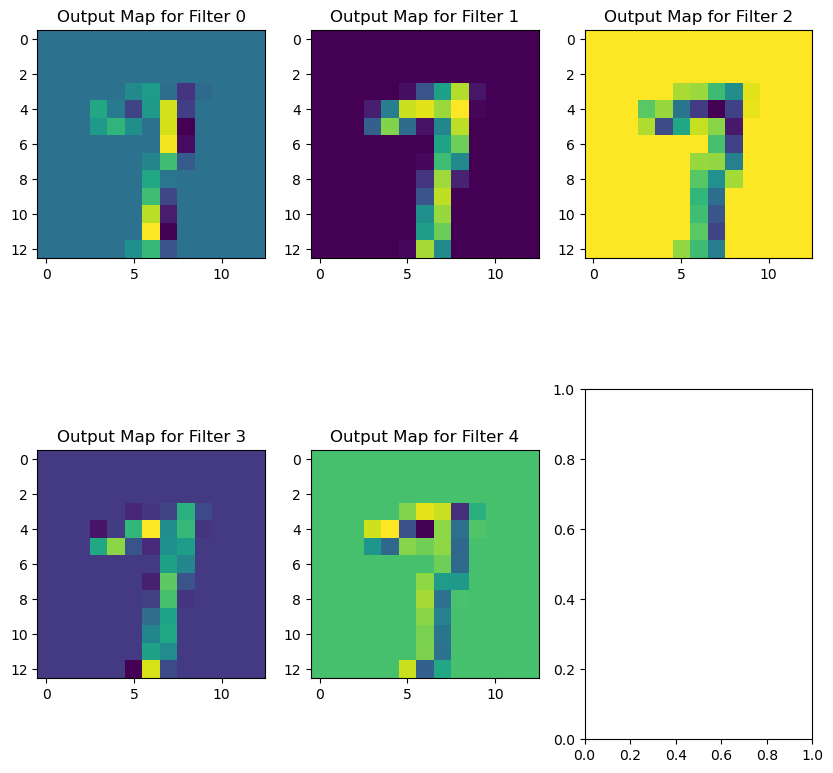

In [166]:
fig,ax = plt.subplots(2,3, figsize=(10,10))
ax=ax.flatten()
for i in range(num_filters):
    ax[i].imshow(output_map[i,:,:])
    ax[i].set_title(f'Output Map for Filter {i}')


# Adding the Bias

Now, we can extend this further, by adding the bias value to each output map:

In [167]:
num_filters = len(kernels)
stride = 2

out_height = (image_height - filter_height)//stride + 1
out_width = out_height

output_map = jnp.zeros((num_filters, out_height,out_height))

for i in range(out_height):
    for j in range(out_width):
        # Extract the segment of the image to which we convolve
        image_segment = sample[i*stride:i*stride+filter_height,j*stride:j*stride+filter_width]

        for f in range(num_filters):
            filter_to_apply = kernels[f]
            # apply the convolution (cross-correlation) which is simply
            # the sum of the element-wise product of the two identicaly shaped
            # matrices, and save this to the correct index of the output
            
            # THE ONLY CHANGE HERE, IS TO SIMPLY ADD THE REPSECTIVE BIAS SCALAR
            conv_res = jnp.sum(filter_to_apply*image_segment)+biases[f]

            # inefficient to use jax like this (copying the output array every time), but will keep the code simple
            output_map = output_map.at[f,i,j].set(conv_res)


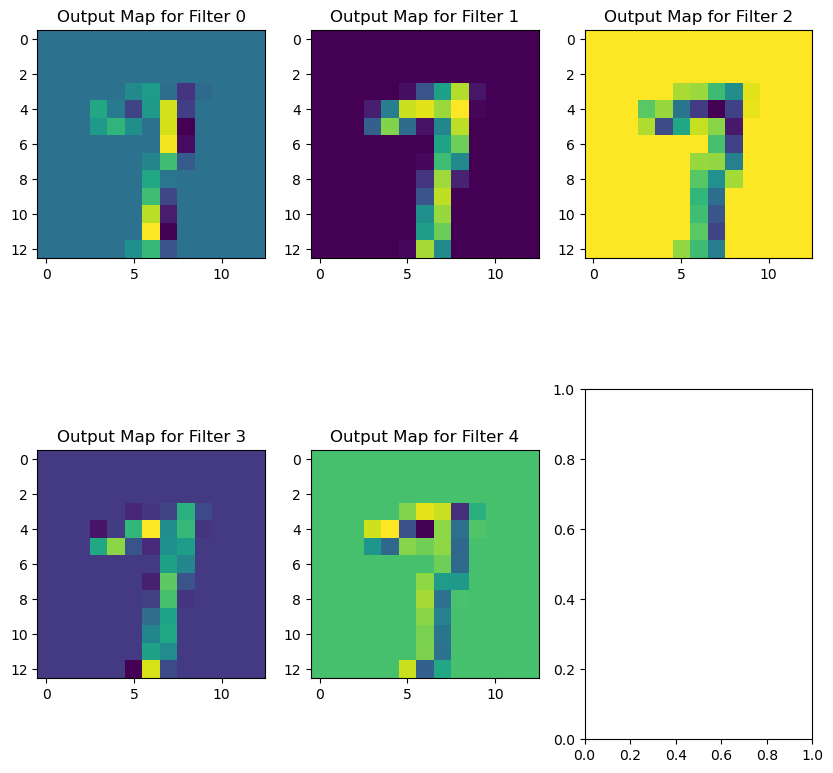

In [168]:
fig,ax = plt.subplots(2,3, figsize=(10,10))
ax=ax.flatten()
for i in range(num_filters):
    ax[i].imshow(output_map[i,:,:])
    ax[i].set_title(f'Output Map for Filter {i}')


# Implementing MaxPool

Using our understanding of stride, implementing max-pooling is quite straightforward.

Consider a maxpool of dimension (S,S), applied with a stride of S. In this case, the output will be of dimension $\lfloor\frac{D_i+1}{S}\rfloor$. It is important that $D_i$ should be divisible by S. **Why?** There are ways around this in practice, which we will see later.

We will take the output of our Stride 1 CNN feature map:

In [173]:
num_filters = len(kernels)

out_height = image_height - filter_height + 1
out_width=out_height

output_map = jnp.zeros((num_filters, out_height,out_height))

for i in range(out_height):
    for j in range(out_width):
        # Extract the segment of the image to which we convolve
        image_segment = sample[i:i+filter_height,j:j+filter_width]

        for f in range(num_filters):
            filter_to_apply = kernels[f]
            # apply the convolution (cross-correlation) which is simply
            # the sum of the element-wise product of the two identicaly shaped
            # matrices, and save this to the correct index of the output
            conv_res = jnp.sum(filter_to_apply*image_segment)

            # inefficient to use jax like this (copying the output array every time), but will keep the code simple
            output_map = output_map.at[f,i,j].set(conv_res)


Applying Pooling to each output channel/the output of each filter:

In [213]:

# the number of channels/number of filter outputs
num_channels = output_map.shape[0]
pool_size = 2

#remember, our input is now the feature map from the CNN output
input_dim = output_map.shape[1]

out_height = (input_dim + 1)//pool_size
out_width=out_height

pool_output = jnp.zeros((num_channels, out_height,out_height))

for f in range(num_channels):
    for i in range(out_height):
        for j in range(out_width):
            ## VERY SIMILAR LOGIC TO APPLY CONVOLUTION WITH STRIDE
            image_segment = output_map[f,i*pool_size:i*pool_size+pool_size,j*pool_size:j*pool_size+pool_size]
            # here, instead of applying a convolution, we take a maximum
            pool_res = jnp.max(image_segment)
            # inefficient to use jax like this (copying the output array every time), but will keep the code simple
            pool_output = pool_output.at[f,i,j].set(pool_res)


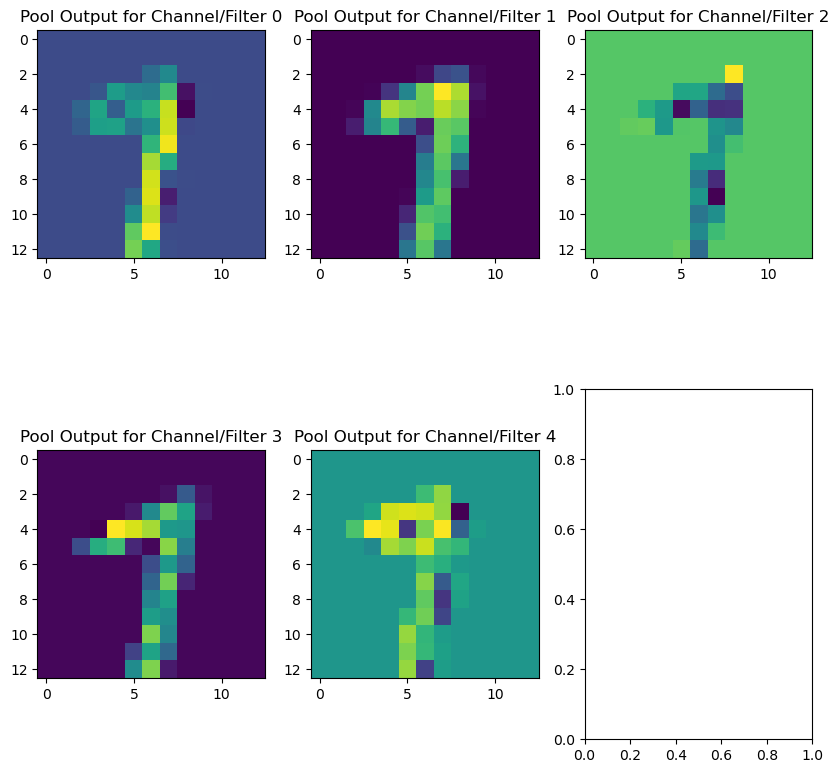

In [215]:
fig,ax = plt.subplots(2,3, figsize=(10,10))
ax=ax.flatten()
for i in range(num_filters):
    ax[i].imshow(pool_output[i,:,:])
    ax[i].set_title(f'Pool Output for Channel/Filter {i}')


# Implementing Padding

Observe that when we apply a CNN filter to an image, we have seen that the dimension of the outputted feature map is smaller than the inputted image - the bigger the filter size, the larger this reduction in dimension.

Sometimes, this is undesirable

1. It can sometimes make the outputted dimensions akward to manage
2. When we consider the filters to be a form of *pattern matching*, we can imagine situations whereby a subset of that pattern exsts at the edge of the image, that isn't detected by standard appliation of convolutional filters.

Consider the function describing the relationship between input and output ($D_o$ dimensions for a CNN filter:

\begin{equation}\displaystyle
   D_o=\lfloor\frac{ D_i - D_f}{S}\rfloor +1
\end{equation}

Which, for a 28x8 image, with a 3x3 filter, results in $D_o=\lfloor\frac{28-3}{1}\rfloor+1=26$.

If we wanted our output to have dimension 28 to match the indput dimesnion, what would our input size have to be?

I.e. $28=\lfloor\frac{X-3}{1}\rfloor+1$, from which we can compute $X = 30$.

This means that, if our original image had size 30x30, our output would have size 28x28.

The idea of padding, is to add a ring of 0 values on the border of the input image, to produce a different output dimension, while minimally altering the computation. We denote the amount of padding (`padding=0`, `padding=1`, `padding=2`, ...) as the number of rings of 0s we place on the border of the inputted image, as per the following diagram:


<img src='https://miro.medium.com/v2/resize:fit:1400/1*I4GFJGxqUhBAptEdPLAwiQ.png' width='750px'/>

**Key question**: how much padding do we need to apply to transform our 28x28 image to have dimension 30x30?

In PyTorch, you have two choices for padding:

1. You may speecify directly what level of padding to apply `padding=0`, `padding=1`, `padding=2`, ...
2. You may specify `padding='same'`, which will automatically compute the level of padding required to ensur the outputted feature map has the same dimension as the input

(30, 30)

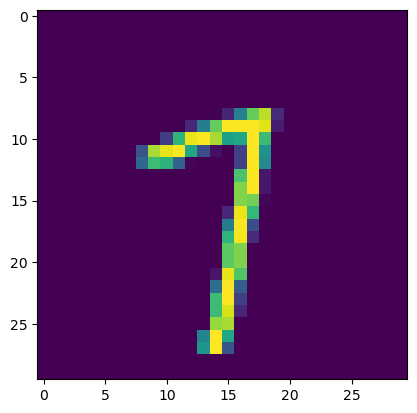

In [225]:
padding = 1

image_height=sample.shape[0]
image_width=sample.shape[1]

# create a big 0 matrix, the size of the final padded image
padded_image = jnp.zeros((image_height+2*padding,image_width+2*padding))
# copy the image into the centre of the 0 matrix, to give the padded image
padded_image=padded_image.at[padding:-padding,padding:-padding].set(sample)
plt.imshow(padded_image)
padded_image.shape

We can now observe that the image has been transformed by padding to have shape (30,30) - you can see this best at the bottom of the viusalisation

## Combining Padding into Our Convolution Implementation

In [248]:
num_filters = len(kernels)
stride = 1
padding = 1
filter_height = 3

image_height=sample.shape[0]
image_width=sample.shape[1]

padded_image = jnp.zeros((image_height+2*padding,image_width+2*padding))
padded_image=padded_image.at[padding:-padding,padding:-padding].set(sample)

# NOW UPDATE THE image height and width

padded_height = padded_image.shape[0]
padded_width = padded_image.shape[1]

out_height = (padded_height - filter_height)//stride + 1
out_width = out_height

output_map = jnp.zeros((num_filters, out_height,out_height))

for i in range(out_height):
    for j in range(out_width):
        # Extract the segment of the image to which we convolve
        # working on the padde image
        image_segment = padded_image[i*stride:i*stride+filter_height,j*stride:j*stride+filter_width]

        for f in range(num_filters):
            filter_to_apply = kernels[f]
            # apply the convolution (cross-correlation) which is simply
            # the sum of the element-wise product of the two identicaly shaped
            # matrices, and save this to the correct index of the output
            
            # THE ONLY CHANGE HERE, IS TO SIMPLY ADD THE REPSECTIVE BIAS SCALAR
            conv_res = jnp.sum(filter_to_apply*image_segment)+biases[f]

            # inefficient to use jax like this (copying the output array every time), but will keep the code simple
            output_map = output_map.at[f,i,j].set(conv_res)


In [249]:
output_map.shape

(5, 30, 30)

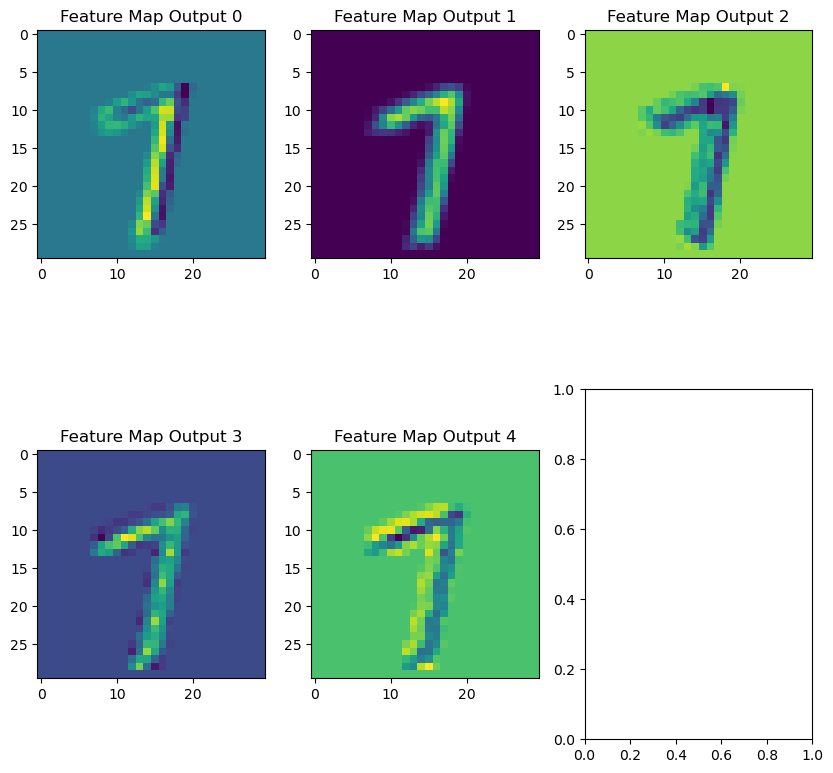

In [250]:
fig,ax = plt.subplots(2,3, figsize=(10,10))
ax=ax.flatten()
for i in range(num_filters):
    ax[i].imshow(output_map[i,:,:])
    ax[i].set_title(f'Feature Map Output {i}')

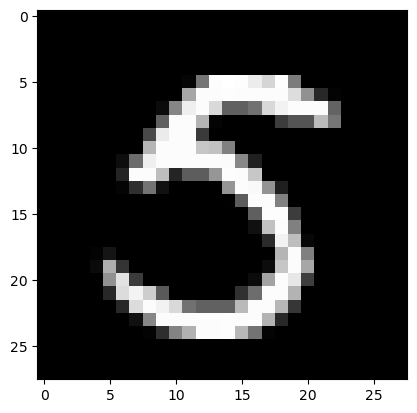

In [73]:
plt.imshow(x_input_data[random.randint(0,59999)], cmap='grey')

# Combining All of our Components to Create a Hand-Crafted CNN Layer

**Key change** to the data. We now will passs inputs with shape (1,28,28) -- incorporating channel information makes it much easier to link the CNN layers together

In [290]:

class CNN_layer:
    def __init__(self, num_filters, filter_size, stride, padding, use_bias):
        self.kernels = jax.random.normal(jax_key, (num_filters,filter_size,filter_size))
        if use_bias:
            self.biases = jax.random.normal(jax_key, (num_filters))
        self.num_filters=num_filters
        self.filter_size=filter_size
        self.stride = stride
        self.padding = padding
        self.use_bias=use_bias
    
    def apply(self, input_data):
        # make sure the input is of the form (channels, W, H)
        assert len(input_data.shape)==3
        input_channels = input_data.shape[0]
        
        # the number of output channels is input_channels*num_filters -- as we apply all filters 
        # to all channels
        
        input_height=input_data.shape[1]
        input_width=input_data.shape[2]
        print(input_height)
        padding = self.padding
        padded_image = jnp.zeros((input_channels, input_height+2*padding,input_width+2*padding))
        
        if padding>0:
            padded_image=padded_image.at[:,padding:-padding,padding:-padding].set(input_data)
        else:
            padded_image=input_data
        padded_height = padded_image.shape[1]
        padded_width = padded_image.shape[2]

        out_height = (padded_height - self.filter_size)//self.stride + 1
        out_width = out_height
        
        
        output_map = jnp.zeros((self.num_filters*input_channels, out_height,out_height))

        for i in range(out_height):
            for j in range(out_width):
                # Extract the segment of the image to which we convolve
                # working on the padde image
                stride=self.stride
                
                for c in range(input_channels):
                    image_segment = padded_image[c,i*stride:i*stride+self.filter_size,j*stride:j*stride+self.filter_size]

                    for f in range(self.num_filters):
                        filter_to_apply = self.kernels[f]
                        # apply the convolution (cross-correlation) which is simply
                        # the sum of the element-wise product of the two identicaly shaped
                        # matrices, and save this to the correct index of the output

                        # THE ONLY CHANGE HERE, IS TO SIMPLY ADD THE REPSECTIVE BIAS SCALAR
                        if self.use_bias:
                            conv_res = jnp.sum(filter_to_apply*image_segment)+self.biases[f]
                        else:
                            conv_res = jnp.sum(filter_to_apply*image_segment)

                        
                        output_map = output_map.at[c*f+f,i,j].set(conv_res)
        return output_map


In [291]:
C = CNN_layer(5,3,1,0,True)

In [292]:
sample = sample.reshape(1,28,28)

In [293]:
out_map = C.apply(sample)

28


In [294]:
out_map.shape

(5, 26, 26)

And similarly for pooling:

In [296]:
class Pooling_layer:
    def __init__(self, pool_size):
        self.pool_size=pool_size
    def apply(self, input_data):
        # make sure the input is of the form (channels, W, H)
        assert len(input_data.shape)==3

        # the number of channels/number of filter outputs
        num_channels = input_data.shape[0]
        input_dim = input_data.shape[1]
        pool_size=self.pool_size
        out_height = (input_dim + 1)//pool_size
        out_width=out_height

        pool_output = jnp.zeros((num_channels, out_width,out_height))

        for f in range(num_channels):
            for i in range(out_height):
                for j in range(out_width):
                    image_segment = output_map[f,i*pool_size:i*pool_size+pool_size,j*pool_size:j*pool_size+pool_size]
                    pool_res = jnp.max(image_segment)
                    pool_output = pool_output.at[f,i,j].set(pool_res)

        return pool_output
    

In [297]:
P = Pooling_layer(2)

In [298]:
pooled_out = P.apply(out_map)

In [299]:
pooled_out.shape

(5, 13, 13)

To this, we can apply an activation:

In [300]:
act = jax.nn.relu(pooled_out)

And then further CNN layers:

In [304]:
C2 = CNN_layer(1,3,1,0,True)
c2_out = C2.apply(act)
P2 = Pooling_layer(3)
pool2_out = P2.apply(c2_out)

13


In [305]:
pool2_out.shape

(5, 4, 4)

And we can finally flatten this, to add a fully connected final layer with 10 neurons corresponding to predicted class:

In [306]:
flatened_out = pool2_out.flatten()

In [307]:
flatened_out.shape

(80,)

In [308]:
## Initialise the parameters 
W_out = jax.random.normal(jax_key, (80,10))
b_out = jnp.zeros(10)

## Apply the layer to the input:
layer_out = flatened_out@W_out+b_out
print(layer_out)

[-7.6329203   0.32065475 -0.05834365 -3.6310713  -8.435335    2.2895577
  2.383164    8.159391   -2.566569   -0.7306529 ]


And at last, apply a softmax activation:

In [310]:
final_out = jax.nn.softmax(layer_out)
final_out.round(2)

Array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.98999995, 0.        , 0.        ],      dtype=float32)

How many weights and biases are in this model?

1. CNN Layer 1: 5x filters, of sape (3x3) - total parameters 5x3x3 + 5 = 50
2. CNN Layer 2: 1x filters, of sape (3x3) - total parameters 1x3x3 + 1 = 10
3. Final fully-connected layer, input dimension 80, output dimension 10 - 80x10+10=810

Total: 810+10+50=870

This is still just 10.3% of the size of the smallest possible fully-connected model!

# Exercise (Difficulat) - Undgraded, but to further your own understanding if you wish to consider this at an advanced level

**BONUS (HARD)** 


1. Consider `dilation`. Read up on this, and attempt to implement it yourself. It is a concept that has gained a lot of traction in recent years.
2. Consider using Jax to calculate gradients, and apply manually back-propogate updates to the weights and biases in the fully-connected and CNN layers 